In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import *
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from scipy import interp
from sklearn.metrics import roc_auc_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Set two decimal points for display
pd.options.display.float_format = "{:.2f}".format

# Load the Data

In [4]:
armada= pd.read_csv("C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/May 2020 Interim Analysis Data for Manuscripts/ARMADA_TBSCORES_MAY2020.csv")
armada.shape

(1083, 189)

In [5]:
armada.assmnt.value_counts()

1    817
2    266
Name: assmnt, dtype: int64

In [6]:
armada.head()

,ptid,assmnt,site,cohort2,LANGUAGE,AGE,gender_rc,ethnicity_rc,race_tb_rc,racetb_w,...,VisualAc_FCTScore,VisualAc_Raw,VisualAc_svalogmar,VisualAc_svasnellen,VisualAc_UCSScore,WIN_Raw_L,WIN_Raw_R,WIN_Thresh_L,WIN_Thresh_R,race_summary
0,1.45635,1,Emory,6,en-US,82,2,1,2,0,...,60.00,82.00,-0.04,20/16-3,95.00,20.00,18.00,10.00,11.60,2
1,1.46421,1,Emory,4,en-US,88,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1.46421,2,Emory,4,en-US,89,1,1,1,1,...,NaN,76.00,0.08,20/20-4,82.00,0.00,0.00,26.00,26.00,1
3,1.46422,1,Emory,3,en-US,88,2,1,1,1,...,NaN,70.00,0.20,20/30,70.00,7.00,9.00,20.40,18.80,1
4,1.46422,2,Emory,3,en-US,89,2,1,1,1,...,NaN,77.00,0.06,20/20-3,84.00,5.00,8.00,22.00,19.60,1


In [7]:
cohort ={1:"Gen population healthy aging 85+", 2:"Gen population 65-85", 3:"Gen population MCI",
4:"Gen population AD", 5:"African American mild cognitive impairment",
6:"African American normal controls 65-85", 7:"Spanish Speaking mild cognitive impairment",
8:"Spanish Speaking normal controls 65-85", 9:"Spanish Speaking AD"}

In [8]:
#Rename the value under column cohort2
armada['cohort2'] = armada['cohort2'].map(cohort)

In [9]:
armada.cohort2.value_counts()

Gen population 65-85                          266
Gen population MCI                            140
Gen population healthy aging 85+              138
Spanish Speaking normal controls 65-85        130
African American normal controls 65-85        128
Spanish Speaking mild cognitive impairment    125
Gen population AD                              85
African American mild cognitive impairment     46
Spanish Speaking AD                            25
Name: cohort2, dtype: int64

In [10]:
#filter by assmnt = 1
armada = armada[armada.assmnt==1]

In [11]:
edu={1:"None",
2 :"Less than HS",
3 :"Less than HS",
4 :"Less than HS",
5 :"Less than HS",
6 :"Less than HS",
7 :"Less than HS",
8 :"Less than HS",
9 :"Less than HS",
10 :"Less than HS",
11 :"Less than HS",
12 :"Less than HS",
13 :"Less than HS",
14 :"Less than HS",
16 :"High School",
18 :"Some College",
20 :"Some College",
21 :"College Degree",
22 :"Graduate Degree",
23 :"Graduate Degree",
24 :"Graduate Degree",
25 :"Some College",
26 :"Some College",
27 :"Some College",
28 :"None",
999:"Unknown"}

In [12]:
#genpop['EDUCATION'] = genpop['EDUCATION'].map(edu)

# 85 Norm

In [13]:
select = [ 'Gen population 65-85', 'Gen population healthy aging 85+']
genpop = armada[armada.cohort2.isin(select)]

# Raw to Scaled Score (ss) for use in Age-corrected Formulas

##  Adults (18-85 years old) page2


In [14]:
#Raw_to_ScaledScore
cut_bins = [0, 1.55, 2.07, 2.18, 2.43, 3.78, 5.96, 6.68, 7.2, 7.59, 7.90, 8.18, 8.51, 8.76, 9.03, 9.31, 9.65, 9.87, 9.99, 100]
genpop['DCCS_ss'] = pd.cut(genpop['DCCS_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 1.92, 4.18, 4.45, 5.11, 6.24, 6.93, 7.51, 7.9, 8.2, 8.45, 8.75, 8.96, 9.19, 9.4, 9.58, 9.72, 9.87,9.99,100]
genpop['Flanker_ss'] = pd.cut(genpop['Flanker_CScore'], bins=cut_bins, labels=list(range(19)))

cut_bins = [0, 2, 4, 5, 7, 9,11,12,14,15,16,17,18,19,20,21,22,24,25,26]
genpop['LSWM_ss'] = pd.cut(genpop['LSWM_Raw'], bins=cut_bins, labels=list(range(19)))

In [15]:
cut_bins = [200, 217.6, 257.35, 293.24, 303.79, 333.22, 352.61, 382.38, 415.59, 442.62, 481.43, 521.53, 552.56, 599.04, 625.89, 653.76, 677.94, 689.94, 700.89, 722.27, 778.57,800.00]
genpop['PSM_ss'] = pd.cut(genpop['PSM_CScore'], bins=cut_bins, labels=list(range(21)))

In [16]:
cut_bins = [0,16,24,27,29,33,38,42,46,49,53,57,61,64,68,72,75,78,81,84,97,130]
genpop['PCPS_ss'] = pd.cut(genpop['PCPS_Raw'], bins=cut_bins, labels=list(range(21)))

In [17]:
cut_bins = [-30,-12.19,-4.75,-3.69,-1.97,-1.05,-0.01,1.07,2.14,3.03,3.96,4.84,5.73,6.81,7.56,8.23,8.84,9.16,9.35,9.97,16.36,20.00]
genpop['ORR_ss'] = pd.cut(genpop['ORR_Theta'], bins=cut_bins, labels=list(range(21)))

In [18]:
cut_bins = [-15,-10.25,-4.78,-2.94,-0.84,0.46,1.39,2.18,3,3.74,4.42,4.95,5.57,6.25,7.15,7.95,8.77,9.57,9.92,10.62,12.73,15]
genpop['TPVT_ss'] = pd.cut(genpop['TPVT_Theta'], bins=cut_bins, labels=list(range(21)))

# Appendix 2.2 Scaled Scores to Age-corrected scores

In [19]:
#DCCS
def DAge_correct(ss, age):
    rv =100 + 15 * (ss-(14.82-9.83*(age/100)))/(2.17-0.62*(age/100))/1.29
    return rv

In [20]:
genpop['DCCS_AC'] = genpop.apply(lambda x: DAge_correct(x.DCCS_ss, x.AGE), axis=1)

In [21]:
genpop['DCCS_Diff']=genpop['DCCS_ACSScore']-genpop['DCCS_AC']

In [22]:
genpop[['AGE','DCCS_CScore','DCCS_ss','DCCS_AC','DCCS_ACSScore','DCCS_Diff']]

,AGE,DCCS_CScore,DCCS_ss,DCCS_AC,DCCS_ACSScore,DCCS_Diff
13,68,7.17,7,92.45,92.00,-0.45
17,74,6.28,6,89.50,89.00,-0.50
19,91,7.98,10,129.87,NaN,NaN
25,86,7.53,8,111.61,NaN,NaN
37,87,7.37,8,112.35,NaN,NaN
...,...,...,...,...,...,...
812,69,7.66,9,106.43,106.00,-0.43
813,71,8.43,11,121.24,121.00,-0.24
817,76,8.39,11,124.99,125.00,0.01
822,83,6.69,7,102.38,102.00,-0.38


In [23]:
#Flanker
def FAge_correct(ss, age):
    rv =100 + 15 * (ss-(14.38-8.92*(age/100)))/(2.28-0.63*(age/100))/1.28
    return rv

In [24]:
genpop['Flanker_AC'] = genpop.apply(lambda x: FAge_correct(x.Flanker_ss, x.AGE), axis=1)

In [25]:
genpop['Flanker_Diff']=genpop['Flanker_ACSScore']-genpop['Flanker_AC']

In [26]:
genpop[['AGE','Flanker_CScore','Flanker_ss','Flanker_AC','Flanker_ACSScore','Flanker_Diff']]

,AGE,Flanker_CScore,Flanker_ss,Flanker_AC,Flanker_ACSScore,Flanker_Diff
13,68,7.33,6,85.35,85.00,-0.35
17,74,6.73,5,82.04,82.00,-0.04
19,91,7.63,7,105.06,NaN,NaN
25,86,6.61,5,88.48,NaN,NaN
37,87,6.80,5,89.04,NaN,NaN
...,...,...,...,...,...,...
812,69,7.95,8,98.57,99.00,0.43
813,71,8.43,9,106.10,106.00,-0.10
817,76,7.68,7,96.09,96.00,-0.09
822,83,7.57,7,100.16,100.00,-0.16


In [27]:
#List Sort
def LAge_correct(ss, age):
    rv =100 + 15 * (ss-(11.98-7.37*(age/100)**2))/(2.36-0.34*(age/100))/1.23
    return rv

In [28]:
genpop['LSWM_AC'] = genpop.apply(lambda x: FAge_correct(x.LSWM_ss, x.AGE), axis=1)

In [29]:
genpop['LSWM_Diff']=genpop['LSWM_ACSScore']-genpop['LSWM_AC']

In [31]:
genpop[['AGE', 'LSWM_ss','LSWM_Raw','LSWM_AC','LSWM_ACSScore','LSWM_Diff']]

,AGE,LSWM_ss,LSWM_Raw,LSWM_AC,LSWM_ACSScore,LSWM_Diff
13,68,8,15.00,98.01,97.00,-1.01
17,74,11,18.00,120.81,118.00,-2.81
19,91,5,10.00,91.33,NaN,NaN
25,86,9,16.00,115.45,NaN,NaN
37,87,6,12.00,95.81,NaN,NaN
...,...,...,...,...,...,...
812,69,7,13.00,92.22,92.00,-0.22
813,71,8,15.00,99.70,98.00,-1.70
817,76,8,15.00,102.60,102.00,-0.60
822,83,5,10.00,86.82,89.00,2.18


In [32]:
#Picture Sequence Memory
def PSMAge_correct(ss, age):
    rv =100 + 15 * (ss-(14.06-8.48*(age/100)))/(2.43-0.72*(age/100))/1.25
    return rv

In [34]:
genpop['PSM_AC'] = genpop.apply(lambda x: PSMAge_correct(x.PSM_ss, x.AGE), axis=1)

In [35]:
genpop['PSM_Diff']=genpop['PSM_ACSScore']-genpop['PSM_AC']

In [36]:
genpop[['AGE', 'PSM_ss','PSM_CScore','PSM_AC','PSM_ACSScore','PSM_Diff']]

,AGE,PSM_ss,PSM_CScore,PSM_AC,PSM_ACSScore,PSM_Diff
13,68,8,418.40,98.18,98.00,-0.18
17,74,9,478.17,107.69,108.00,0.31
19,91,6,357.34,97.68,NaN,NaN
25,86,4,320.37,81.66,NaN,NaN
37,87,8,432.90,108.77,NaN,NaN
...,...,...,...,...,...,...
812,69,8,434.35,98.70,99.00,0.30
813,71,7,399.19,93.50,94.00,0.50
817,76,10,491.88,115.20,115.00,-0.20
822,83,5,340.97,86.76,87.00,0.24


In [38]:
#Pattern comparison
def PCAge_correct(ss, age):
    rv =100 + 15 * (ss-(14.68-9.62*(age/100)))/(2.33-0.74*(age/100))/1.24
    return rv

In [39]:
genpop['PCPS_AC'] = genpop.apply(lambda x: PCAge_correct(x.PCPS_ss, x.AGE), axis=1)

In [40]:
genpop['PCPS_Diff']=genpop['PCPS_ACSScore']-genpop['PCPS_AC']

In [41]:
genpop[['AGE','PCPS_Raw','PCPS_ss','PCPS_AC','PCPS_ACSScore','PCPS_Diff']]

,AGE,PCPS_Raw,PCPS_ss,PCPS_AC,PCPS_ACSScore,PCPS_Diff
13,68,41.00,6,85.84,106.00,20.16
17,74,23.00,1,55.47,55.00,-0.47
19,91,39.00,6,100.54,NaN,NaN
25,86,28.00,3,75.67,NaN,NaN
37,87,27.00,2,69.08,NaN,NaN
...,...,...,...,...,...,...
812,69,37.00,5,79.77,93.00,13.23
813,71,39.00,6,87.60,101.00,13.40
817,76,33.00,4,76.95,84.00,7.05
822,83,37.00,5,88.05,102.00,13.95


In [42]:
#Oral Reading
def OAge_correct(ss, age):
    rv =100 + 15 * (ss-(9.68-0.65*(age/100)))/(1.81-1.19*(age/100))/1.26
    return rv

In [43]:
genpop['ORR_AC'] = genpop.apply(lambda x: OAge_correct(x.ORR_ss, x.AGE), axis=1)

In [44]:
genpop['ORR_Diff']=genpop['ORR_ACSScore']-genpop['ORR_AC']

In [46]:
genpop[['ORR_Theta','ORR_ss','ORR_AC','ORR_ACSScore','ORR_Diff']]

,ORR_Theta,ORR_ss,ORR_AC,ORR_ACSScore,ORR_Diff
13,3.99,10,109.06,99.00,-10.06
17,7.22,13,148.69,113.00,-35.69
19,7.51,13,164.04,NaN,NaN
25,5.68,11,128.44,NaN,NaN
37,6.55,12,144.34,NaN,NaN
...,...,...,...,...,...
812,4.97,11,121.29,104.00,-17.29
813,6.96,13,146.65,113.00,-33.65
817,5.84,12,136.99,108.00,-28.99
822,7.42,13,155.88,112.00,-43.88


In [47]:
#Pic Vocabulary
def PVAge_correct(ss, age):
    rv =100 + 15 * (ss-(11.41-0.57*(age/100)**(-1)))/(1.86-1.12*(age/100))/1.24
    return rv

In [48]:
genpop['TPVT_AC'] = genpop.apply(lambda x: OAge_correct(x.TPVT_ss, x.AGE), axis=1)

In [49]:
genpop['TPVT_Diff']=genpop['TPVT_ACSScore']-genpop['TPVT_AC']

In [51]:
genpop[['TPVT_Theta','TPVT_ss','TPVT_AC','TPVT_ACSScore','TPVT_Diff'] ]

,TPVT_Theta,TPVT_ss,TPVT_AC,TPVT_ACSScore,TPVT_Diff
13,5.31,11,120.96,102.00,-18.96
17,9.27,16,187.11,124.00,-63.11
19,7.45,14,180.42,NaN,NaN
25,6.59,13,158.71,NaN,NaN
37,4.54,10,113.61,NaN,NaN
...,...,...,...,...,...
812,7.14,13,145.37,111.00,-34.37
813,10.25,18,208.32,134.00,-74.32
817,8.32,15,176.43,119.00,-57.43
822,8.14,15,184.83,119.00,-65.83


In [55]:
#Fluid Composite
#[((Mean of DCC, Flanker, List Sort, Pic Seq Mem, & Pattern Comparison Age-corrected Standard Scores) 
#– 100.15) / 10.10] 
def Fluid_composite(a, b, c, d, e):
    avg = (a+b+c+d+e)/ 5
    rv = 100+ 15*(avg-100.15)/10.10
    return rv
    

In [56]:
genpop['CFC_AC'] = genpop.apply(lambda x: Fluid_composite(x.DCCS_AC, x.Flanker_AC, x.LSWM_AC, x.PSM_AC, x.PCPS_AC), axis=1)

In [57]:
genpop['CFC_Diff']=genpop['CFC_ACSScore']-genpop['CFC_AC']

In [59]:
genpop[['CFC_ACSScore','CFC_AC','CFC_Diff']]

,CFC_ACSScore,CFC_AC,CFC_Diff
13,93.00,87.85,5.15
17,86.00,86.56,-0.56
19,NaN,107.05,NaN
25,NaN,91.72,NaN
37,NaN,92.36,NaN
...,...,...,...
812,96.00,92.56,3.44
813,106.00,102.19,3.81
817,106.00,104.48,1.52
822,94.00,89.13,4.87


In [60]:
#Crystallized Composite
#[((Mean of Oral Reading & Picture Vocabulary Age-corrected Standard  

def Crystallized_composite(a, b):
    avg = (a+b)/ 2
    rv = 100+ 15*(avg-100.18)/13.64
    return rv

In [61]:
genpop['CCC_AC'] = genpop.apply(lambda x: Crystallized_composite(x.ORR_AC, x.TPVT_AC), axis=1)

In [62]:
genpop['CCC_Diff']=genpop['CCC_ACSScore']-genpop['CCC_AC']

In [63]:
genpop[['CCC_ACSScore','CCC_AC','CCC_Diff']]

,CCC_ACSScore,CCC_AC,CCC_Diff
13,101.00,116.31,-15.31
17,120.00,174.47,-54.47
19,NaN,179.23,NaN
25,NaN,147.72,NaN
37,NaN,131.67,NaN
...,...,...,...
812,108.00,136.45,-28.45
813,125.00,185.01,-60.01
817,115.00,162.17,-47.17
822,117.00,177.17,-60.17


In [64]:
#Total cognition composite
def Total_composite(a, b):
    avg = (a+b)/ 2
    rv = 100+ 15*(avg-100.02)/12.93
    return rv

In [65]:
genpop['CTC_AC'] = genpop.apply(lambda x: Crystallized_composite(x.CCC_AC, x.CFC_AC), axis=1)

In [66]:
genpop['CTC_Diff']=genpop['CTC_ACSScore']-genpop['CTC_AC']

In [67]:
genpop[['CTC_AC','CTC_ACSScore','CTC_Diff']]

,CTC_AC,CTC_ACSScore,CTC_Diff
13,102.09,96.00,-6.09
17,133.36,103.00,-30.36
19,147.24,NaN,NaN
25,121.49,NaN,NaN
37,113.01,NaN,NaN
...,...,...,...
812,115.75,103.00,-12.75
813,147.75,118.00,-29.75
817,136.45,112.00,-24.45
822,136.26,106.00,-30.26


In [71]:
select=['ptid', 'assmnt', 'cohort2','EDUCATION','gender_rc','AGE','ethnicity_rc',
 'CCC_ACSScore',
 'CFC_ACSScore',
 'CTC_ACSScore',
 'DCCS_ACSScore',
 'Flanker_ACSScore',
 'LSWM_ACSScore',
 'ORR_ACSScore',
 'PCPS_ACSScore',
 'PSM_ACSScore',
 'TPVT_ACSScore',
 'DCCS_ss',
 'Flanker_ss',
 'LSWM_ss',
 'PSM_ss',
 'PCPS_ss',
 'ORR_ss',
 'TPVT_ss',
 'DCCS_AC',
 'Flanker_AC',
 'LSWM_AC',
 'PSM_AC',
 'PCPS_AC',
 'ORR_AC',
 'TPVT_AC',
 'CFC_AC',
 'CCC_AC',
 'CTC_AC',
'DCCS_Diff',
 'Flanker_Diff',
 'LSWM_Diff',
 'PSM_Diff',
 'PCPS_Diff',
 'ORR_Diff',
 'TPVT_Diff',
 'CFC_Diff',
 'CCC_Diff',
 'CTC_Diff']

In [70]:
cd

['DCCS_Diff',
 'Flanker_Diff',
 'LSWM_Diff',
 'PSM_Diff',
 'PCPS_Diff',
 'ORR_Diff',
 'TPVT_Diff',
 'CFC_Diff',
 'CCC_Diff',
 'CTC_Diff']

In [72]:
genpop[select].head()

,ptid,assmnt,cohort2,EDUCATION,gender_rc,AGE,ethnicity_rc,CCC_ACSScore,CFC_ACSScore,CTC_ACSScore,...,DCCS_Diff,Flanker_Diff,LSWM_Diff,PSM_Diff,PCPS_Diff,ORR_Diff,TPVT_Diff,CFC_Diff,CCC_Diff,CTC_Diff
13,1.50313,1,Gen population 65-85,21.00,2,68,1,101.00,93.00,96.00,...,-0.45,-0.35,-1.01,-0.18,20.16,-10.06,-18.96,5.15,-15.31,-6.09
17,1.52966,1,Gen population 65-85,21.00,1,74,1,120.00,86.00,103.00,...,-0.50,-0.04,-2.81,0.31,-0.47,-35.69,-63.11,-0.56,-54.47,-30.36
19,1.53368,1,Gen population healthy aging 85+,22.00,2,91,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,1.64163,1,Gen population healthy aging 85+,23.00,1,86,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,1.70772,1,Gen population healthy aging 85+,22.00,1,87,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


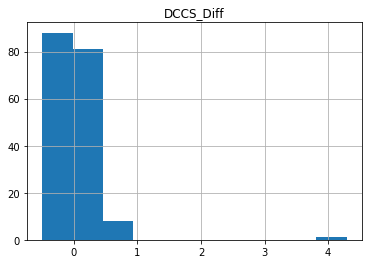

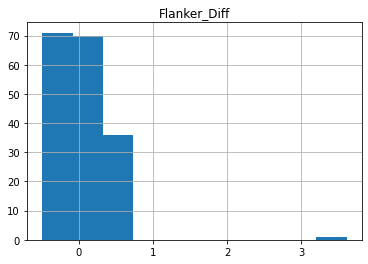

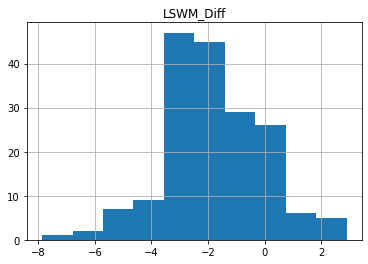

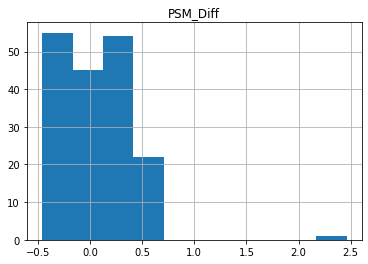

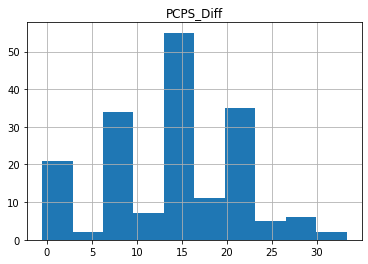

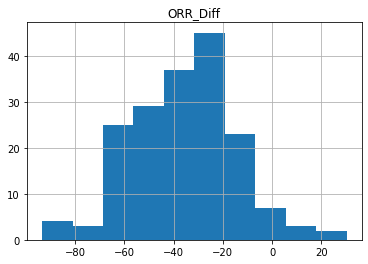

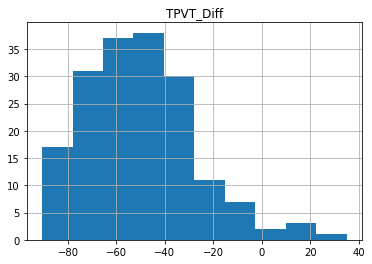

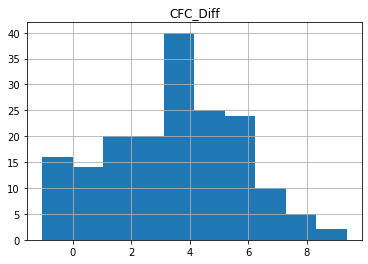

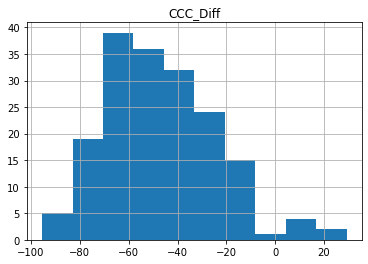

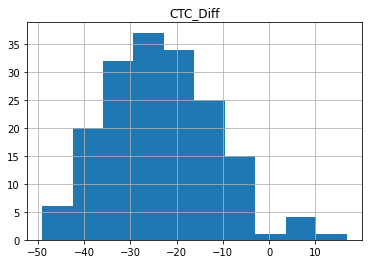

In [76]:
for diff in cd:
    genpop.hist(column=diff)

In [73]:
genpop=genpop.round(2)

In [74]:
genpop[select].to_csv('C:/Users/tsb7592/Box/ARMADA Operations/Data and Analysis/85 Norms/age_corrected_data.csv', index=False)

In [58]:
genpop[['DCCS_AC', 'Flanker_AC', 'LSWM_AC','PSM_AC','PCPS_AC', 'ORR_AC', 'TPVT_AC']].mean()

DCCS_AC      110.88
Flanker_AC    96.54
LSWM_AC      109.18
PSM_AC       104.67
PCPS_AC       83.83
ORR_AC       153.17
TPVT_AC      164.72
dtype: float64